In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# Load data
folder_path = "../results/base/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")

Loaded 4218 valid JSON result files from '../results/base/' and its subfolders.


In [9]:
# Replace this with your actual guess data
# Example dummy counts — you should fill in your real results here
model_names = ["gpt", "llama", "gemini", "claude", "qwen", "deepseek", "mistral"]

results = {model: {gm: 0 for gm in model_names} for model in model_names}

for entry in data:
    model_0 = entry["model_general_name_0"].lower()
    model_1 = entry["model_general_name_1"].lower()
    guess_0 = entry["agent_0_guess"].lower()
    guess_1 = entry["agent_1_guess"].lower()

    if guess_0 in model_names:
        results[model_0][guess_0] += 1
    else:
        results[model_0]["other"] += 1
    if guess_1 in model_names:
        results[model_1][guess_1] += 1
    else:
        results[model_1]["other"] += 1

# Convert to DataFrame
df = pd.DataFrame(results).T

# Reindex the DataFrame rows and columns
df = df.reindex(index=sorted(model_names), columns=sorted(model_names), fill_value=0)

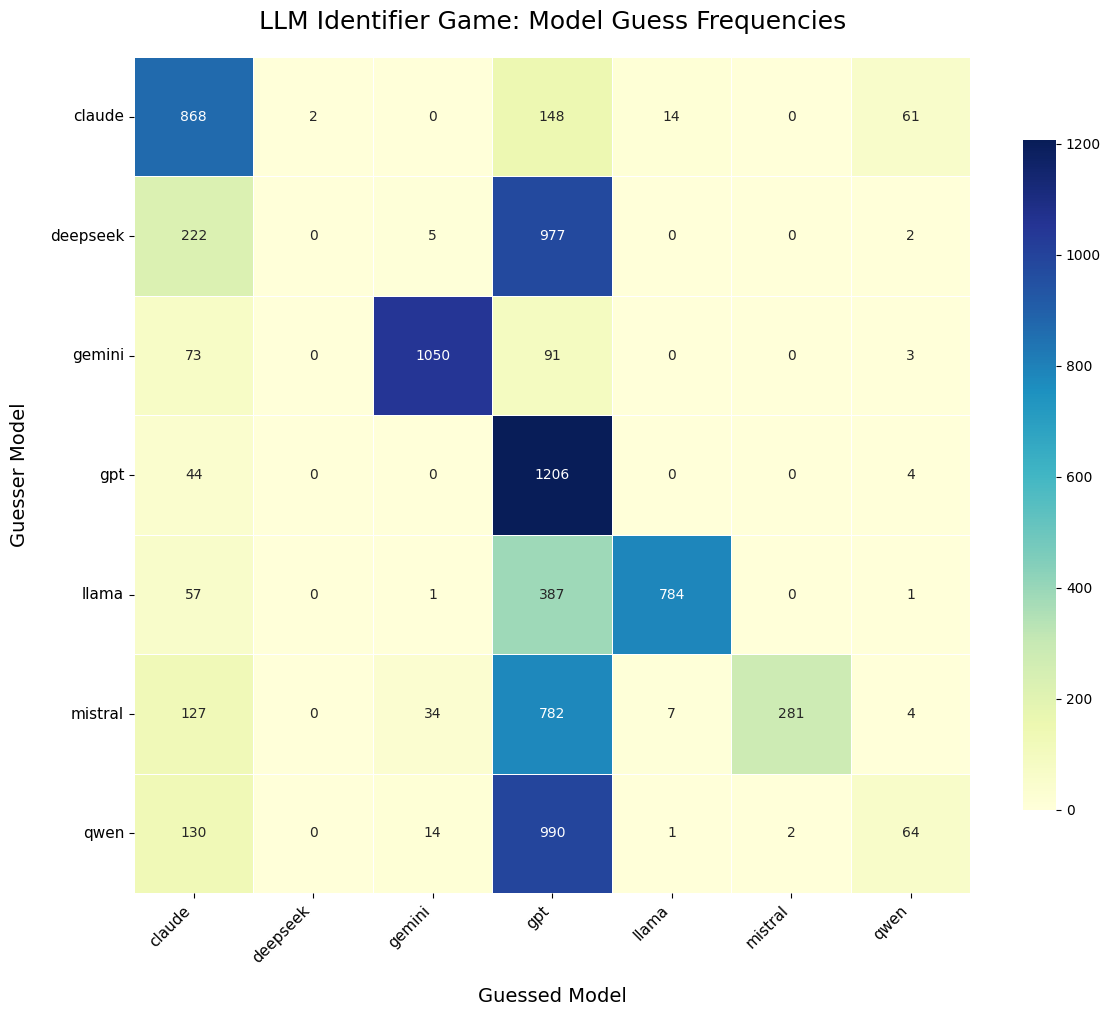

In [15]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    df,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)

# Axis titles
plt.title("LLM Identifier Game: Model Guess Frequencies", fontsize=18, pad=20)
plt.xlabel("Guessed Model", fontsize=14, labelpad=15)
plt.ylabel("Guesser Model", fontsize=14, labelpad=15)

# Tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

# Tight layout to prevent label cut-off
plt.tight_layout()

plt.savefig("4.1.1.eps", dpi=300, bbox_inches='tight')
plt.show()

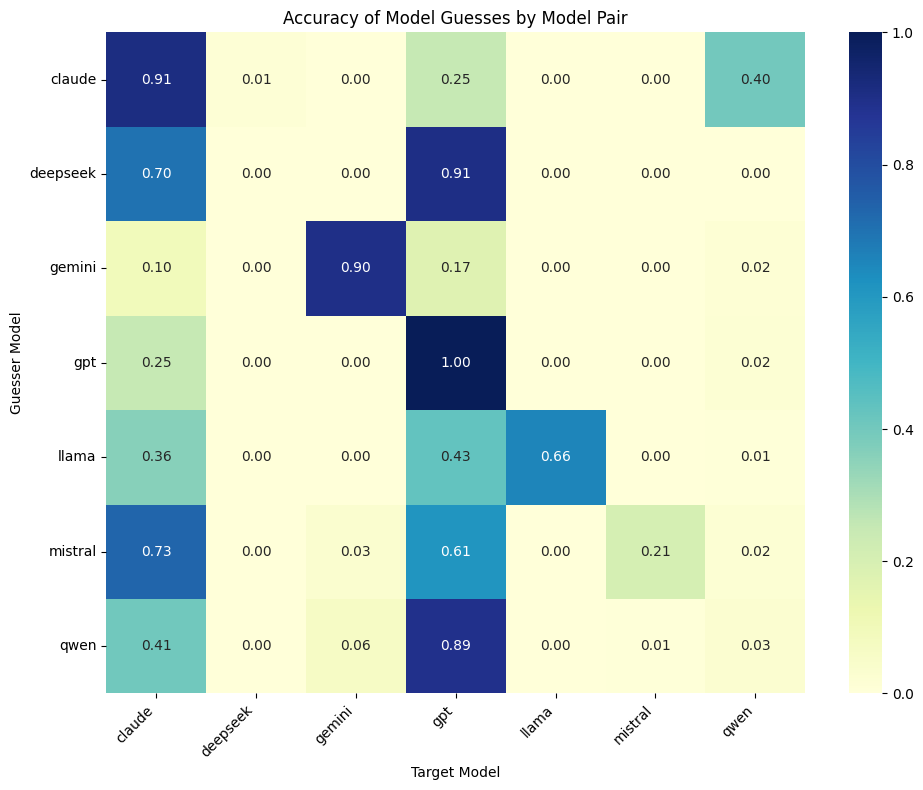

In [14]:
# Initialize counters
correct_counts = defaultdict(lambda: defaultdict(int))
total_counts = defaultdict(lambda: defaultdict(int))

# Normalize helper
def normalize(model_name):
    return model_name.lower().replace("**", "").strip()

# Populate counts
for run in data:
    m0 = normalize(run['model_general_name_0'])
    m1 = normalize(run['model_general_name_1'])
    guess_0 = normalize(run['agent_0_guess'])
    guess_1 = normalize(run['agent_1_guess'])

    # Model 0 guessing Model 1
    total_counts[m0][m1] += 1
    if guess_0 and guess_0 == m1:
        correct_counts[m0][m1] += 1

    # Model 1 guessing Model 0
    total_counts[m1][m0] += 1
    if guess_1 and guess_1 == m0:
        correct_counts[m1][m0] += 1

# Get all model names
models = sorted(set(correct_counts) | set(total_counts))

# Build accuracy matrix
accuracy_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
accuracy_df = pd.DataFrame(index=models, columns=models, dtype=float)

for guesser in models:
    for target in models:
        total = total_counts[guesser][target]
        correct = correct_counts[guesser][target]
        if total > 0:
            accuracy_df.loc[guesser, target] = correct / total
        else:
            accuracy_df.loc[guesser, target] = None

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_df.astype(float), annot=True, fmt=".2f", cmap='YlGnBu', vmin=0, vmax=1)
plt.title("Accuracy of Model Guesses by Model Pair")
plt.xlabel("Target Model")
plt.ylabel("Guesser Model")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("4.1.2.eps", dpi=300, bbox_inches='tight')
plt.show()